In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix
import time
import os

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 10) 
np.random.seed(42)

In [ ]:
def create_windows(data, look_back=5, look_ahead=3):
    X, y = [], []
    for i in range(len(data) - look_back - look_ahead + 1):
        window = data[i : i + look_back]
        target = data[i + look_back + look_ahead - 1]
        X.append(window)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

def load_data(name, task):
    path_map = {
        'Melborn': '../Datasets/data/dataset/regression/daily-minimum-temperatures-in-melbourne (1).xlsx',
        'Video': '../Datasets/data/dataset/regression/Video surveillance Dataset.xlsx',
        'Glass': '../Datasets/data/dataset/classification/classification-glass.xlsx',
        'Seeds': '../Datasets/data/dataset/classification/classification-seeds.xlsx'
    }
    
    path = path_map.get(name)
    if not path: raise FileNotFoundError(f"Path for {name} not found")

    scaler = StandardScaler()
    
    if task == 'regression':
        try: df = pd.read_excel(path, header=None)
        except: df = pd.read_csv(path, header=None)
        
        raw = df.values.flatten().reshape(-1, 1)
        data_norm = scaler.fit_transform(raw).flatten()
        X, y = create_windows(data_norm, look_back=5, look_ahead=3)
        return X, y, None
        
    elif task == 'classification':
        df = pd.read_excel(path, header=None)
        X_raw = df.iloc[:, :-1].values
        y_raw = df.iloc[:, -1].values
        
        X = scaler.fit_transform(X_raw)
        le = LabelEncoder()
        y_int = le.fit_transform(y_raw)
        
        ohe = OneHotEncoder(sparse_output=False)
        y_ohe = ohe.fit_transform(y_int.reshape(-1, 1))
        
        y_ohe = y_ohe * 0.8 + 0.1 
        
        return X, y_ohe, y_int

In [8]:
class CombinedActivation:
    def __init__(self, mode='F1'):
        self.mode = mode
        
    def forward(self, x, params):
        a, b, g, d = params[0], params[1], params[2], params[3]
        t1, t2, t3, t4 = params[4], params[5], params[6], params[7]
        
        self.logsig = 1.0 / (1.0 + np.exp(-np.clip(t1 * x, -20, 20)))
        term1 = a * self.logsig
        
        self.tansig = np.tanh(t2 * x)
        term2 = b * self.tansig
        
        self.relu_in = t3 * x
        self.relu = np.maximum(0, self.relu_in)
        term3 = g * self.relu
        
        res = term1 + term2 + term3
        
        if self.mode == 'F1':
            res += d * (t4 * x)
            
        return res

    def derivatives(self, x, params, grad_output):
        a, b, g, d = params[0], params[1], params[2], params[3]
        t1, t2, t3, t4 = params[4], params[5], params[6], params[7]
        
        d_logsig = t1 * self.logsig * (1 - self.logsig)
        d_tansig = t2 * (1 - self.tansig**2)
        d_relu = t3 * (self.relu_in > 0).astype(float)
        
        d_out_dx = a * d_logsig + b * d_tansig + g * d_relu
        if self.mode == 'F1':
            d_out_dx += d * t4
            
        grad_x = grad_output * d_out_dx
        
        grads = {}
        grads['alpha'] = np.sum(grad_output * self.logsig, axis=0, keepdims=True)
        grads['beta']  = np.sum(grad_output * self.tansig, axis=0, keepdims=True)
        grads['gamma'] = np.sum(grad_output * self.relu, axis=0, keepdims=True)
        grads['delta'] = np.sum(grad_output * (t4 * x), axis=0, keepdims=True) if self.mode == 'F1' else np.zeros_like(d)
            
        d_t1 = a * x * self.logsig * (1 - self.logsig)
        grads['theta1'] = np.sum(grad_output * d_t1, axis=0, keepdims=True)
        
        d_t2 = b * x * (1 - self.tansig**2)
        grads['theta2'] = np.sum(grad_output * d_t2, axis=0, keepdims=True)
        
        d_t3 = g * x * (self.relu_in > 0).astype(float)
        grads['theta3'] = np.sum(grad_output * d_t3, axis=0, keepdims=True)
        
        d_t4 = d * x if self.mode == 'F1' else np.zeros_like(x)
        grads['theta4'] = np.sum(grad_output * d_t4, axis=0, keepdims=True)
            
        return grad_x, grads

In [9]:
class Layer:
    def __init__(self, input_dim, output_dim, act_mode='F1'):
        self.act_mode = act_mode
        
        limit = np.sqrt(6 / (input_dim + output_dim))
        self.W = np.random.uniform(-limit, limit, (input_dim, output_dim))
        self.b = np.zeros((1, output_dim))
        
        self.flex_params = [
            np.ones((1, output_dim)) * 0.5, # alpha
            np.ones((1, output_dim)) * 0.5, # beta
            np.ones((1, output_dim)) * 0.5, # gamma
            np.ones((1, output_dim)) * 0.2, # delta
            np.random.normal(0, 0.2, (1, output_dim)) + 1.0, 
            np.random.normal(0, 0.2, (1, output_dim)) + 1.0, 
            np.random.normal(0, 0.2, (1, output_dim)) + 1.0, 
            np.random.normal(0, 0.2, (1, output_dim)) + 1.0  
        ]
        
        self.activation = CombinedActivation(act_mode)
        
        self.m = [np.zeros_like(p) for p in [self.W, self.b] + self.flex_params]
        self.v = [np.zeros_like(p) for p in [self.W, self.b] + self.flex_params]
        self.grads = {}

    def forward(self, x):
        self.input = x
        self.net = np.dot(x, self.W) + self.b
        
        if self.act_mode == 'Pureline':
            self.output = self.flex_params[7] * self.net
        else:
            self.output = self.activation.forward(self.net, self.flex_params)
        return self.output

    def backward(self, grad_output):
        N = grad_output.shape[0]
        
        if self.act_mode == 'Pureline':
            t4 = self.flex_params[7]
            d_net = grad_output * t4
            
            self.grads['theta4'] = np.sum(grad_output * self.net, axis=0, keepdims=True)
            for k in ['alpha','beta','gamma','delta','theta1','theta2','theta3']:
                self.grads[k] = np.zeros_like(self.flex_params[0])
        else:
            d_net, flex_grads = self.activation.derivatives(self.net, self.flex_params, grad_output)
            self.grads.update(flex_grads)
            
        self.grads['W'] = np.dot(self.input.T, d_net) / N
        self.grads['b'] = np.sum(d_net, axis=0, keepdims=True) / N
        
        return np.dot(d_net, self.W.T)

class HybridNetwork:
    def __init__(self, layers_dims, scenario='A', k1=0.7, k2=0.3):
        self.layers = []
        self.k1 = k1
        self.k2 = k2
        self.prev_error = None
        for i in range(len(layers_dims) - 1):
            is_out = (i == len(layers_dims) - 2)
            if scenario == 'A':
                mode = 'F1'
            else: # B
                mode = 'Pureline' if is_out else 'F2'
            self.layers.append(Layer(layers_dims[i], layers_dims[i+1], mode))
            
    def forward(self, X):
        out = X
        for l in self.layers: out = l.forward(out)
        return out
        
    def backward(self, y_true, y_pred):
        e_curr = y_pred - y_true

        if self.prev_error is None:
            self.prev_error = np.zeros_like(e_curr)

        e_diff = e_curr - self.prev_error
        self.prev_error = e_curr
        r = self.k1 * e_curr + self.k2 * e_diff

        grad = r * (self.k1 + self.k2)

        for l in reversed(self.layers): grad = l.backward(grad)

    def adam_step(self, lr, t):
        beta1, beta2, eps = 0.9, 0.999, 1e-8
        for l in self.layers:
            params = [l.W, l.b] + l.flex_params
            keys = ['W', 'b', 'alpha', 'beta', 'gamma', 'delta', 'theta1', 'theta2', 'theta3', 'theta4']
            
            for i, k in enumerate(keys):
                g = l.grads[k]
                l.m[i] = beta1 * l.m[i] + (1-beta1) * g
                l.v[i] = beta2 * l.v[i] + (1-beta2) * (g**2)
                m_hat = l.m[i] / (1 - beta1**t)
                v_hat = l.v[i] / (1 - beta2**t)
                
                update = lr * m_hat / (np.sqrt(v_hat) + eps)
                if i==0: l.W -= update
                elif i==1: l.b -= update
                else: l.flex_params[i-2] -= update

    # LM Helpers
    def get_params_flat(self):
        p_list = []
        for l in self.layers:
            p_list.extend([l.W.flatten(), l.b.flatten()])
            for p in l.flex_params: p_list.append(p.flatten())
        return np.concatenate(p_list)
    
    def set_params_flat(self, vec):
        idx = 0
        for l in self.layers:
            s = l.W.size; l.W = vec[idx:idx+s].reshape(l.W.shape); idx+=s
            s = l.b.size; l.b = vec[idx:idx+s].reshape(l.b.shape); idx+=s
            for i in range(8):
                s = l.flex_params[i].size
                l.flex_params[i] = vec[idx:idx+s].reshape(l.flex_params[i].shape)
                idx += s

    def compute_jacobian(self, X):
        N = X.shape[0]
        out = self.forward(X)
        OutDim = out.shape[1]
        n_params = len(self.get_params_flat())
        
        J = np.zeros((N * OutDim, n_params))
        
        for i in range(N):
            self.forward(X[i:i+1])
            for k in range(OutDim):
                grad_vec = np.zeros((1, OutDim))
                grad_vec[0, k] = 1.0
                
                grad = grad_vec
                for l in reversed(self.layers):
                    grad = l.backward(grad)
                
                row = []
                for l in self.layers:
                    row.extend([l.grads['W'].flatten(), l.grads['b'].flatten()])
                    for key in ['alpha','beta','gamma','delta','theta1','theta2','theta3','theta4']:
                        row.append(l.grads[key].flatten())
                J[i*OutDim + k] = np.concatenate(row)
        return J


==================== Processing daily-minimum-temperatures-in-melbourne (1) (regression) ====================

--- Scenario A | Optimizer Adam ---
Adam Ep 20: Tr 0.0136 Ts 0.0117
Adam Ep 40: Tr 0.0135 Ts 0.0117
Adam Ep 60: Tr 0.0134 Ts 0.0116
Adam Ep 80: Tr 0.0134 Ts 0.0116
Adam Ep 100: Tr 0.0134 Ts 0.0116
Adam Ep 120: Tr 0.0134 Ts 0.0116
Adam Ep 140: Tr 0.0134 Ts 0.0116
Done. Time: 0.88s, Final MSE: 0.0116

--- Scenario A | Optimizer LM ---
LM Ep 5: Tr 0.0182 Ts 0.0164 Mu 1.0e-01
LM Ep 10: Tr 0.0129 Ts 0.0115 Mu 1.0e-02
LM Ep 15: Tr 0.0128 Ts 0.0114 Mu 1.0e-01
LM Ep 20: Tr 0.0127 Ts 0.0113 Mu 1.0e+00
LM Ep 25: Tr 0.0127 Ts 0.0113 Mu 1.0e+01
LM Ep 30: Tr 0.0126 Ts 0.0113 Mu 1.0e+00
Done. Time: 21.63s, Final MSE: 0.0113

--- Scenario B | Optimizer Adam ---
Adam Ep 20: Tr 0.0141 Ts 0.0124
Adam Ep 40: Tr 0.0137 Ts 0.0119
Adam Ep 60: Tr 0.0135 Ts 0.0117
Adam Ep 80: Tr 0.0134 Ts 0.0117
Adam Ep 100: Tr 0.0134 Ts 0.0117
Adam Ep 120: Tr 0.0134 Ts 0.0117
Adam Ep 140: Tr 0.0134 Ts 0.0117
Done. 

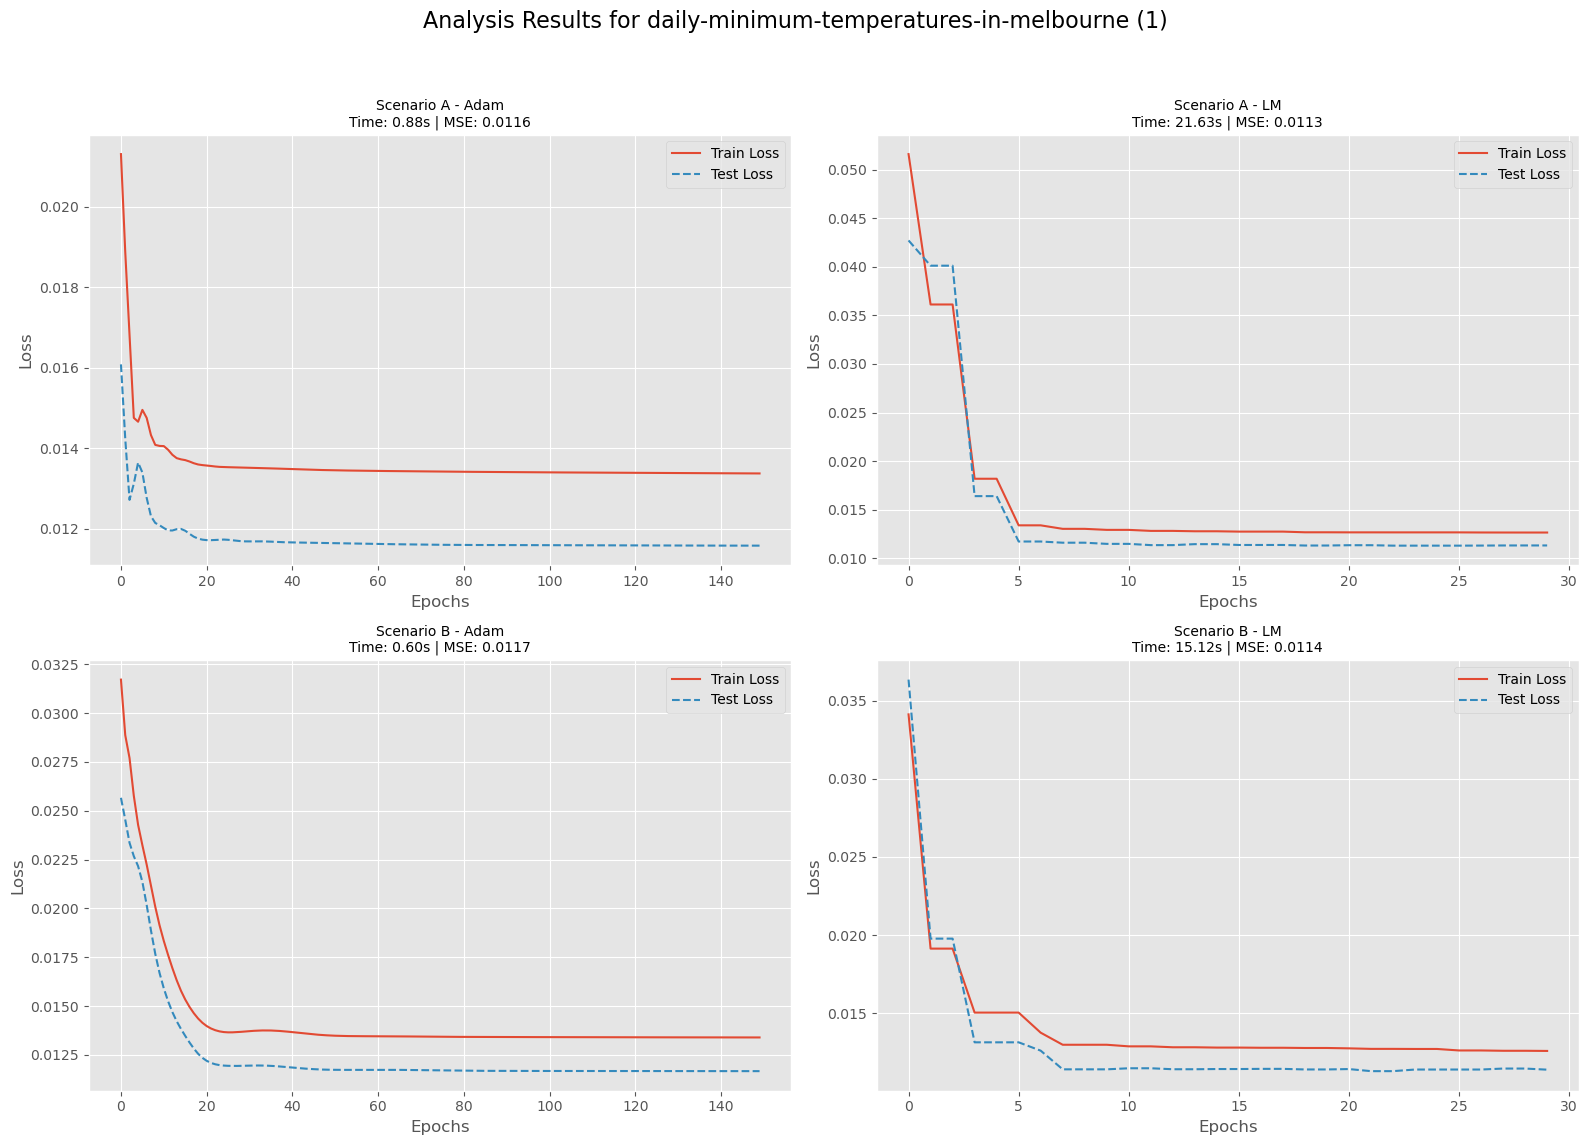


==================== Processing Video surveillance Dataset (regression) ====================

--- Scenario A | Optimizer Adam ---
Adam Ep 20: Tr 0.0118 Ts 0.0106
Adam Ep 40: Tr 0.0069 Ts 0.0073
Adam Ep 60: Tr 0.0064 Ts 0.0068
Adam Ep 80: Tr 0.0061 Ts 0.0065
Adam Ep 100: Tr 0.0058 Ts 0.0061
Adam Ep 120: Tr 0.0055 Ts 0.0058
Adam Ep 140: Tr 0.0051 Ts 0.0054
Done. Time: 1.43s, Final MSE: 0.0052

--- Scenario A | Optimizer LM ---
LM Ep 5: Tr 0.0025 Ts 0.0025 Mu 1.0e-01
LM Ep 10: Tr 0.0006 Ts 0.0005 Mu 1.0e+00
LM Ep 15: Tr 0.0005 Ts 0.0005 Mu 1.0e-01
LM Ep 20: Tr 0.0005 Ts 0.0005 Mu 1.0e+00
LM Ep 25: Tr 0.0005 Ts 0.0005 Mu 1.0e+01
LM Ep 30: Tr 0.0005 Ts 0.0005 Mu 1.0e+00
Done. Time: 33.37s, Final MSE: 0.0005

--- Scenario B | Optimizer Adam ---
Adam Ep 20: Tr 0.0706 Ts 0.0681
Adam Ep 40: Tr 0.0246 Ts 0.0267
Adam Ep 60: Tr 0.0174 Ts 0.0194
Adam Ep 80: Tr 0.0153 Ts 0.0169
Adam Ep 100: Tr 0.0143 Ts 0.0156
Adam Ep 120: Tr 0.0137 Ts 0.0148
Adam Ep 140: Tr 0.0132 Ts 0.0143
Done. Time: 1.23s, Fina

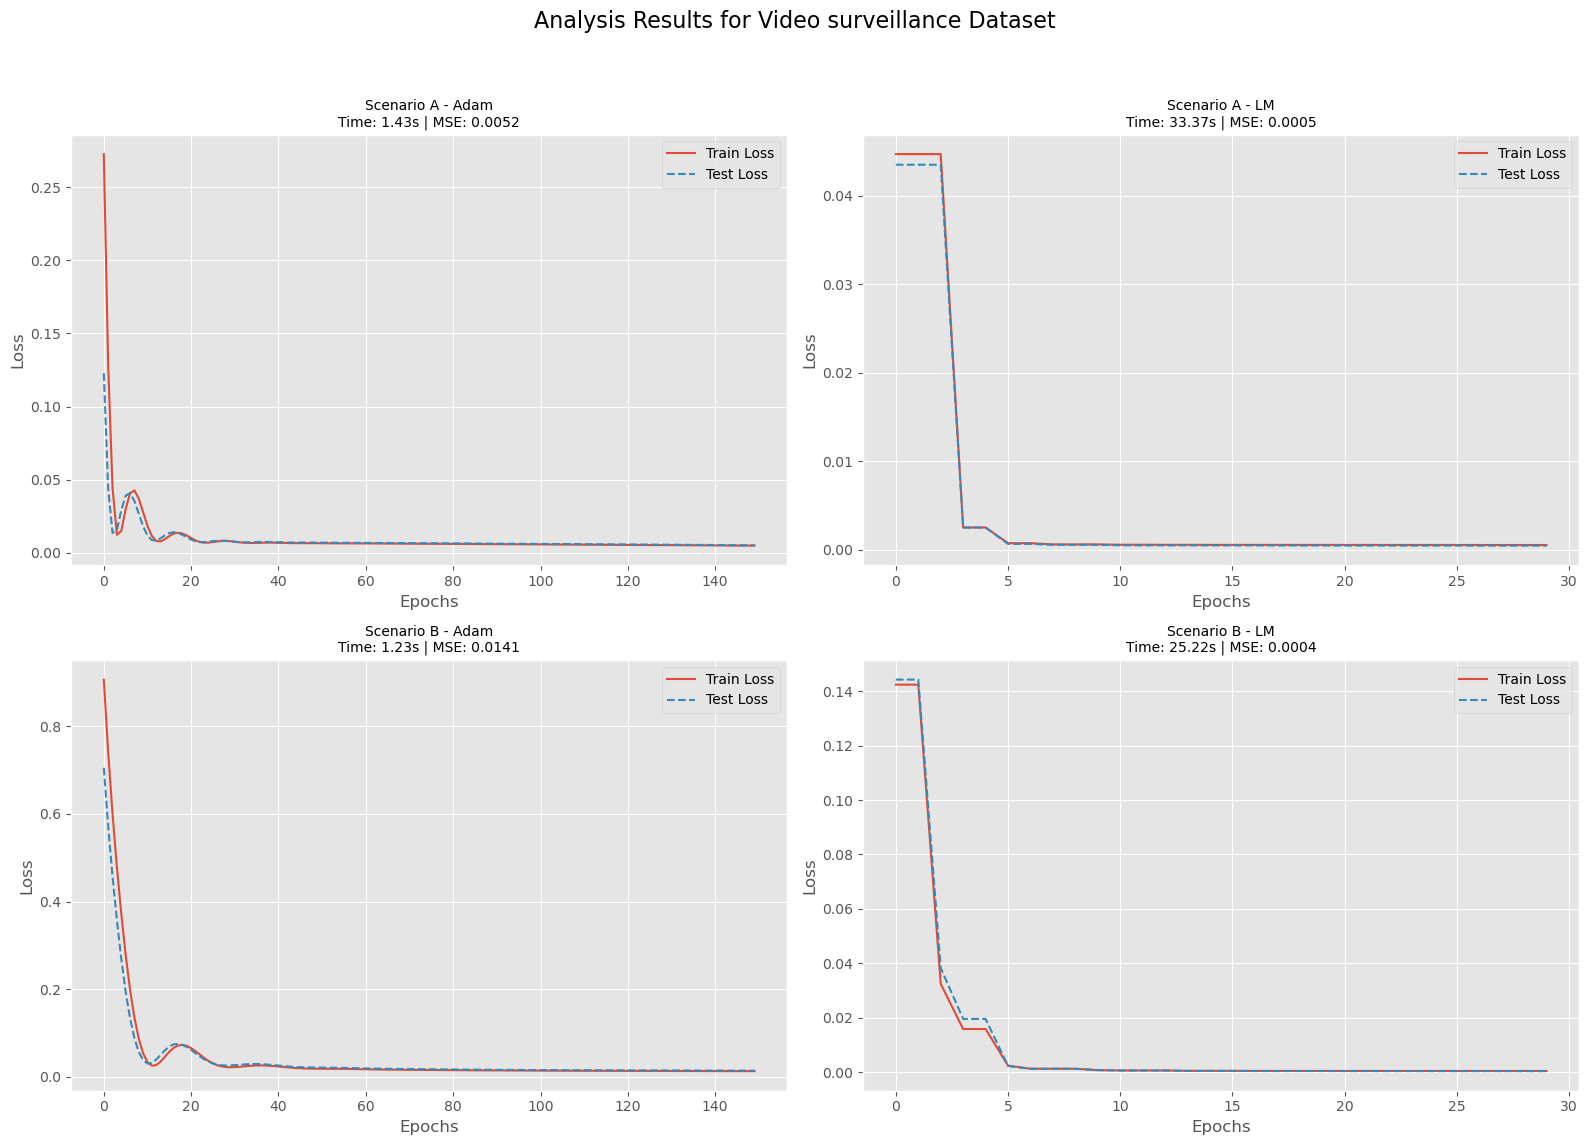


==================== Processing classification-seeds (classification) ====================

--- Scenario A | Optimizer Adam ---
Adam Ep 20: Tr 0.1455 Ts 0.1458
Adam Ep 40: Tr 0.0637 Ts 0.0640
Adam Ep 60: Tr 0.0492 Ts 0.0538
Adam Ep 80: Tr 0.0407 Ts 0.0441
Adam Ep 100: Tr 0.0347 Ts 0.0383
Adam Ep 120: Tr 0.0303 Ts 0.0334
Adam Ep 140: Tr 0.0268 Ts 0.0306
Done. Time: 0.15s, Final Acc: 0.9206

--- Scenario A | Optimizer LM ---
LM Ep 5: Tr 0.1314 Ts 0.1162 Mu 1.0e-01
LM Ep 10: Tr 0.0328 Ts 0.0526 Mu 1.0e-02
LM Ep 15: Tr 0.0050 Ts 0.0252 Mu 1.0e-01
LM Ep 20: Tr 0.0021 Ts 0.0243 Mu 1.0e-02
LM Ep 25: Tr 0.0016 Ts 0.0263 Mu 1.0e-01
LM Ep 30: Tr 0.0009 Ts 0.0277 Mu 1.0e-02
Done. Time: 5.24s, Final Acc: 0.9365

--- Scenario B | Optimizer Adam ---
Adam Ep 20: Tr 0.1846 Ts 0.1780
Adam Ep 40: Tr 0.0744 Ts 0.0713
Adam Ep 60: Tr 0.0546 Ts 0.0592
Adam Ep 80: Tr 0.0466 Ts 0.0501
Adam Ep 100: Tr 0.0410 Ts 0.0440
Adam Ep 120: Tr 0.0368 Ts 0.0400
Adam Ep 140: Tr 0.0337 Ts 0.0370
Done. Time: 0.20s, Final A

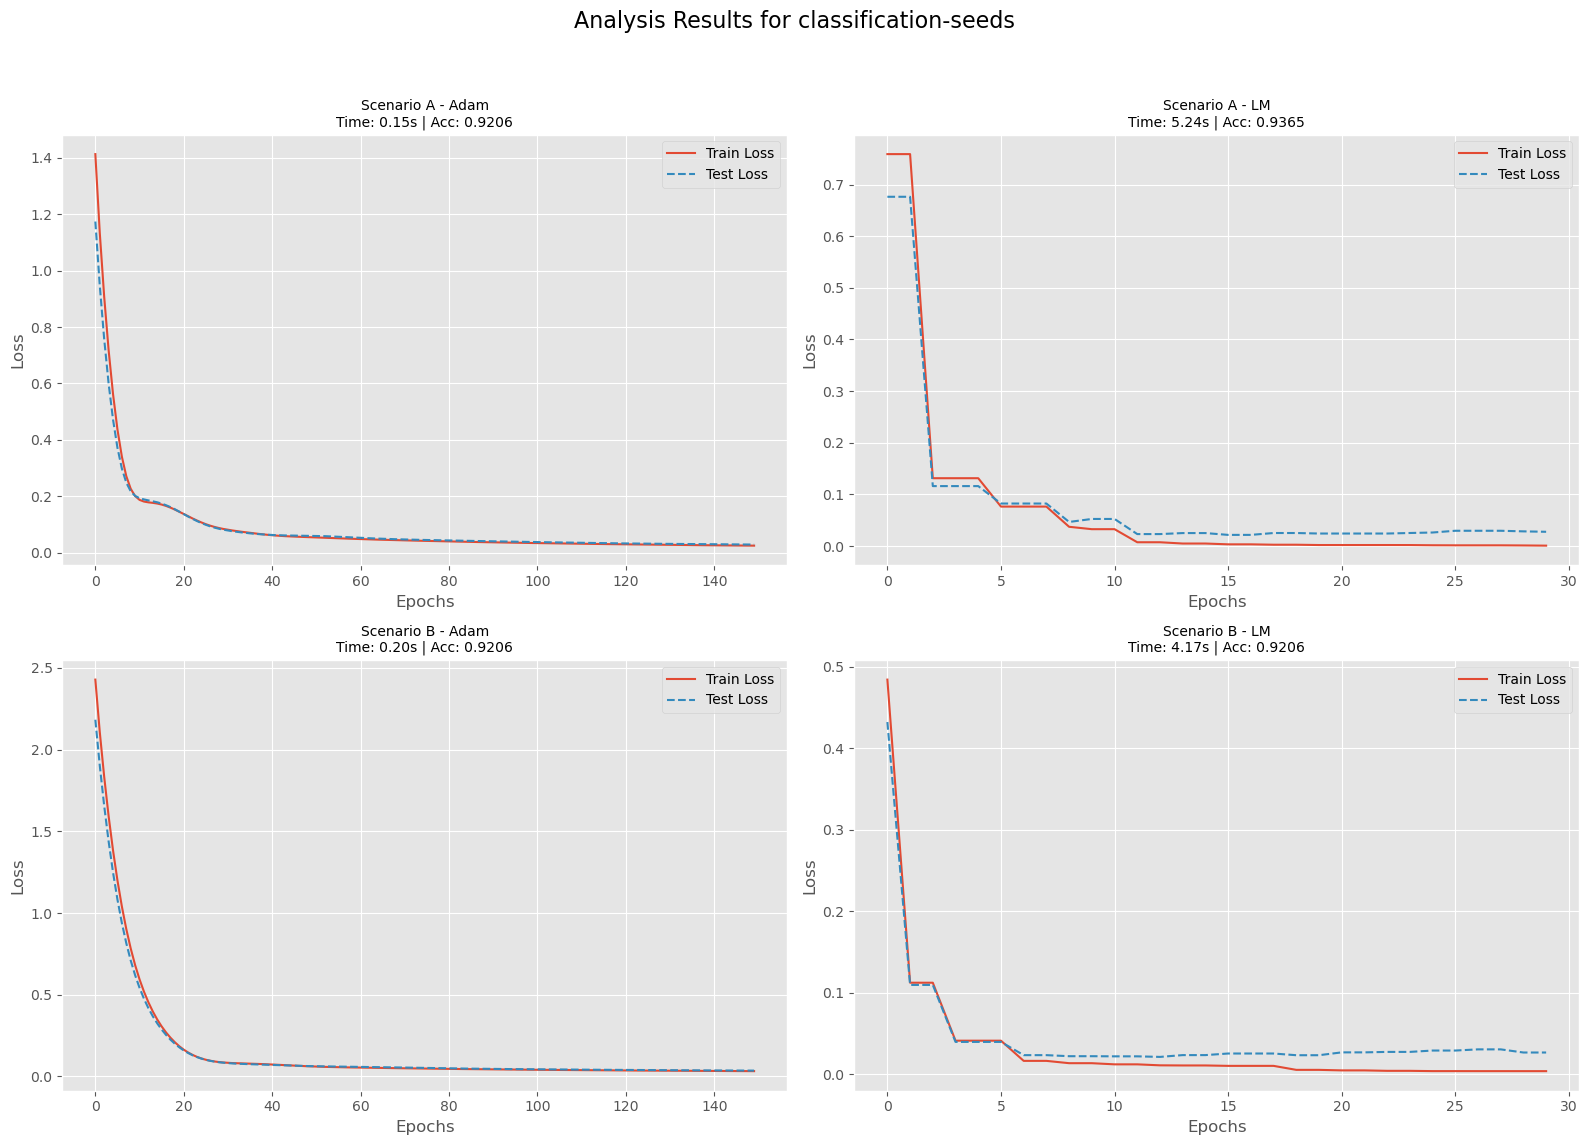


==================== Processing classification-glass (classification) ====================

--- Scenario A | Optimizer Adam ---
Adam Ep 20: Tr 0.0829 Ts 0.0809
Adam Ep 40: Tr 0.0562 Ts 0.0588
Adam Ep 60: Tr 0.0508 Ts 0.0552
Adam Ep 80: Tr 0.0477 Ts 0.0535
Adam Ep 100: Tr 0.0452 Ts 0.0527
Adam Ep 120: Tr 0.0428 Ts 0.0523
Adam Ep 140: Tr 0.0408 Ts 0.0519
Done. Time: 0.19s, Final Acc: 0.7077

--- Scenario A | Optimizer LM ---
LM Ep 5: Tr 0.0601 Ts 0.0709 Mu 1.0e-01
LM Ep 10: Tr 0.0340 Ts 0.0537 Mu 1.0e+00
LM Ep 15: Tr 0.0226 Ts 0.0699 Mu 1.0e-01
LM Ep 20: Tr 0.0125 Ts 0.0765 Mu 1.0e+00
LM Ep 25: Tr 0.0084 Ts 0.0989 Mu 1.0e-01
LM Ep 30: Tr 0.0063 Ts 0.1106 Mu 1.0e+00
Done. Time: 8.98s, Final Acc: 0.6308

--- Scenario B | Optimizer Adam ---
Adam Ep 20: Tr 0.1008 Ts 0.1007
Adam Ep 40: Tr 0.0693 Ts 0.0706
Adam Ep 60: Tr 0.0623 Ts 0.0659
Adam Ep 80: Tr 0.0586 Ts 0.0620
Adam Ep 100: Tr 0.0561 Ts 0.0605
Adam Ep 120: Tr 0.0541 Ts 0.0594
Adam Ep 140: Tr 0.0524 Ts 0.0587
Done. Time: 0.20s, Final A

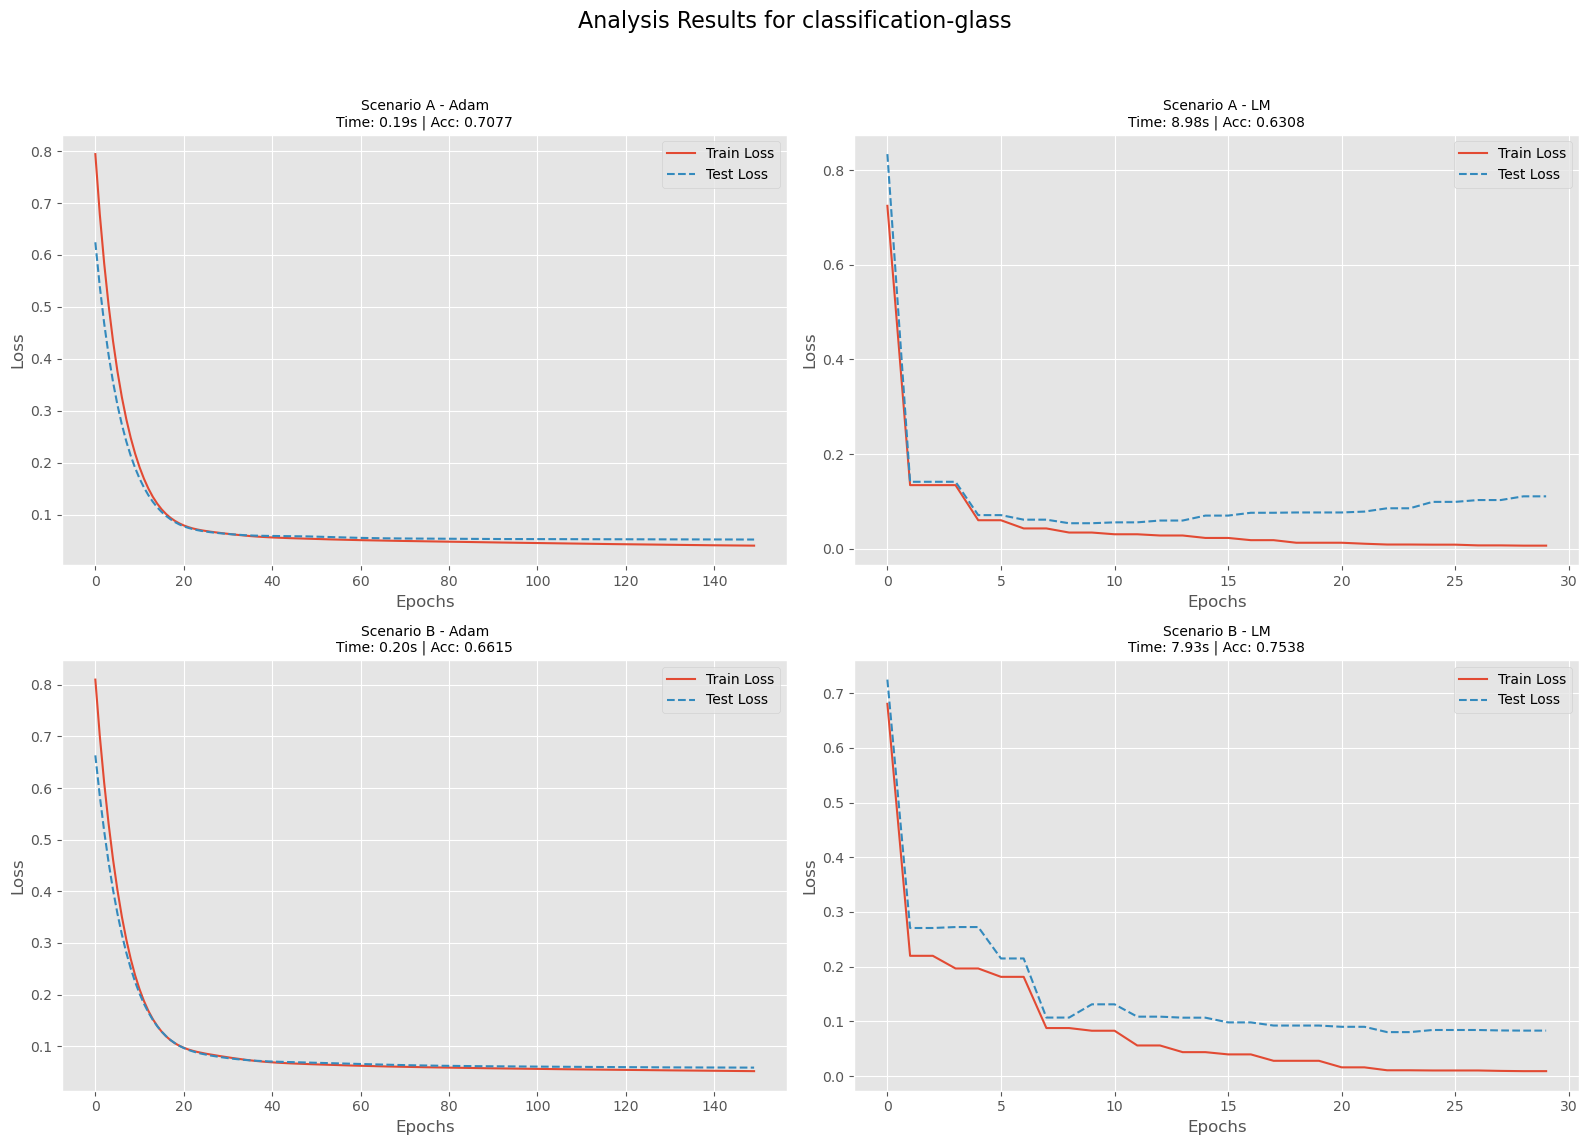

In [10]:
def train_network(X_tr, y_tr, X_ts, y_ts, model, optimizer='Adam', epochs=100):
    start_time = time.time()
    history = {'train': [], 'test': []}
    
    if optimizer == 'Adam':
        lr = 0.005 # Stable LR
        for e in range(1, epochs + 1):
            y_p = model.forward(X_tr)
            model.backward(y_tr, y_p)
            model.adam_step(lr, e)
            
            loss_tr = np.mean((y_tr - y_p)**2)
            y_pt = model.forward(X_ts)
            loss_ts = np.mean((y_ts - y_pt)**2)
            
            history['train'].append(loss_tr)
            history['test'].append(loss_ts)
            
            if e % 20 == 0:
                print(f"Adam Ep {e}: Tr {loss_tr:.4f} Ts {loss_ts:.4f}")
                
    elif optimizer == 'LM':
        mu = 1e-2 
        beta = 10
        min_mu = 1e-7
        max_mu = 1e7
        model.prev_error = None
        
        for e in range(1, epochs + 1):
            y_p = model.forward(X_tr)
            error = (y_tr - y_p).flatten()
            r_vec = error
            mse = np.mean(r_vec**2)
            
            J = model.compute_jacobian(X_tr)
            J = J * (model.k1 + model.k2)
            H = np.dot(J.T, J)
            g = np.dot(J.T, r_vec)
            I = np.eye(H.shape[0])
            
            try:
                dt = np.linalg.solve(H + mu * I, g)
                old_params = model.get_params_flat()
                model.set_params_flat(old_params + dt)
                
                y_p_new = model.forward(X_tr)
                mse_new = np.mean((y_tr - y_p_new)**2)
                
                if mse_new < mse:
                    mu = max(min_mu, mu / beta)
                    mse = mse_new
                else:
                    model.set_params_flat(old_params)
                    mu = min(max_mu, mu * beta)
                    
            except np.linalg.LinAlgError:
                mu = min(max_mu, mu * beta)
            
            y_pt = model.forward(X_ts)
            loss_ts = np.mean((y_ts - y_pt)**2)
            history['train'].append(mse)
            history['test'].append(loss_ts)
            
            if e % 5 == 0:
                print(f"LM Ep {e}: Tr {mse:.4f} Ts {loss_ts:.4f} Mu {mu:.1e}")
                
    duration = time.time() - start_time
    return history, duration


def run_experiment(dataset_path, task_type, hidden_neurons=10, epochs=100):
    ds_name = os.path.basename(dataset_path).split('.')[0]
    print(f"\n{'='*20} Processing {ds_name} ({task_type}) {'='*20}")
    
    try:
        if dataset_path.endswith('.csv'):
            df = pd.read_csv(dataset_path, header=None)
        else:
            df = pd.read_excel(dataset_path, header=None)
    except Exception as e:
        print(f"Error loading file: {e}")
        return

    if task_type == 'regression':
        data = df.values.astype('float32').flatten()
        scaler = MinMaxScaler()
        data = scaler.fit_transform(data.reshape(-1, 1)).flatten()
        X, y = create_windows(data, look_back=5, look_ahead=3)
        
    elif task_type == 'classification':
        data = df.values
        X_raw = data[:, :-1]
        y_raw = data[:, -1]
        
        scaler = StandardScaler()
        X = scaler.fit_transform(X_raw)
        
        ohe = OneHotEncoder(sparse_output=False)
        y = ohe.fit_transform(y_raw.reshape(-1, 1))
        y = y * 0.8 + 0.1
        
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, shuffle=(task_type=='classification')
    )
    
    n_in = X_train.shape[1]
    n_out = y_train.shape[1]
    layer_sizes = [n_in, hidden_neurons, n_out]
    
    scenarios = ['A', 'B']
    optimizers = ['Adam', 'LM']
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    fig.suptitle(f"Analysis Results for {ds_name}", fontsize=16)
    
    plot_idx = 0
    for scenario in scenarios:
        for opt in optimizers:
            print(f"\n--- Scenario {scenario} | Optimizer {opt} ---")
            
            model = HybridNetwork(layer_sizes, scenario=scenario)
            
            current_epochs = epochs + 50 if opt == 'Adam' else min(epochs, 30) # LM سریع است، ایپاک کمتر کافیست
            
            history, dur = train_network(X_train, y_train, X_test, y_test, model, optimizer=opt, epochs=current_epochs)
            
            h_train = history['train']
            h_test = history['test']
            
            y_pred_final = model.forward(X_test)
            if task_type == 'regression':
                final_metric = mean_squared_error(y_test, y_pred_final)
                metric_name = "MSE"
            else:
                y_cls = np.argmax(y_test, axis=1)
                p_cls = np.argmax(y_pred_final, axis=1)
                final_metric = accuracy_score(y_cls, p_cls)
                metric_name = "Acc"
                
            print(f"Done. Time: {dur:.2f}s, Final {metric_name}: {final_metric:.4f}")
            
            ax = axes[plot_idx]
            ax.plot(h_train, label='Train Loss')
            ax.plot(h_test, label='Test Loss', linestyle='--')
            title = f"Scenario {scenario} - {opt}\nTime: {dur:.2f}s | {metric_name}: {final_metric:.4f}"
            ax.set_title(title, fontsize=10)
            ax.set_xlabel("Epochs")
            ax.set_ylabel("Loss")
            ax.legend()
            ax.grid(True)
            
            plot_idx += 1
            
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    safe_name = ds_name.replace(" ", "_")
    plt.savefig(f"{safe_name}_analysis.png")
    plt.show()


# 1. Regression: Melbourne
run_experiment('../Datasets/data/dataset/regression/daily-minimum-temperatures-in-melbourne (1).xlsx', 'regression', hidden_neurons=12, epochs=100)

# 2. Regression: Video
run_experiment('../Datasets/data/dataset/regression/Video surveillance Dataset.xlsx', 'regression', hidden_neurons=10, epochs=100)

# 3. Classification: Seeds
run_experiment('../Datasets/data/dataset/classification/classification-seeds.xlsx', 'classification', hidden_neurons=15, epochs=100)

# 4. Classification: Glass
run_experiment('../Datasets/data/dataset/classification/classification-glass.xlsx', 'classification', hidden_neurons=20, epochs=100)